<a href="https://colab.research.google.com/github/MarkAvilin1/DS-and-ML/blob/main/segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Задание Ultra Pro**

In [ ]:
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras import backend as K 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras import utils 
from google.colab import files 
import matplotlib.pyplot as plt 
from tensorflow.keras.preprocessing import image 
import numpy as np 
from sklearn.model_selection import train_test_split
import time
import random
import glob
import cv2
import os 
from PIL import Image

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
paths = glob.glob('/content/drive/MyDrive/University AI/new_cars/*.png')

In [ ]:
print(paths[-1])

/content/drive/MyDrive/University AI/new_cars/car__300.png


In [ ]:
w, h = 192, 108
num_classes = 2
car_path = '/content/drive/MyDrive/University AI/new_cars/'
mask_path = '/content/drive/MyDrive/University AI/car_masks/'

In [ ]:
data = np.zeros((h, w, 3), dtype=np.uint8)
data[0:256, 0:256] = [0, 0, 255]
red_img = Image.fromarray(data, 'RGB')

data2 = np.ones((h, w, 3), dtype=np.uint8)
data2[0:256, 0:256] = [255, 255, 255]
white = Image.fromarray(data2, 'RGB')

def mask_maker(img_path):
    image_bgr = cv2.imread(img_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    rectangle = (5, 5, 180, 100)
    mask = np.zeros(image_rgb.shape[:2], np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    cv2.grabCut(image_rgb, mask, rectangle, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
    mask_2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    image = image_rgb * mask_2[:, :, np.newaxis]

    im_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    thresh, mask = cv2.threshold(im_gray, 170, 255, cv2.THRESH_BINARY_INV)
    mask = np.reshape(mask, (108, 192, 1))
    temp = image * mask
    temp2 = temp * red_img
    final = temp2 * white
    img_name = img_path.split('/')[-1]
    cv2.imwrite('/content/drive/MyDrive/University AI/car_masks/' + img_name, final)

In [ ]:
# for path in paths:
#   mask_maker(path)

In [ ]:
def get_data(path):
  data = []
  for image in sorted(os.listdir(path)):
    data.append(img_to_array(load_img(path + image, target_size=(h, w))))
  data = np.stack(data).astype('uint8')
  return np.array(data)

In [ ]:
def show_images(img):
  n = 5 
  fig, axs = plt.subplots(1, n, figsize=(25, 5)) 
  for i in range(n): 
      rsl = random.choice(img)
      axs[i].imshow(rsl) 
  plt.show()

In [ ]:
X = get_data(car_path)
Y = get_data(mask_path)

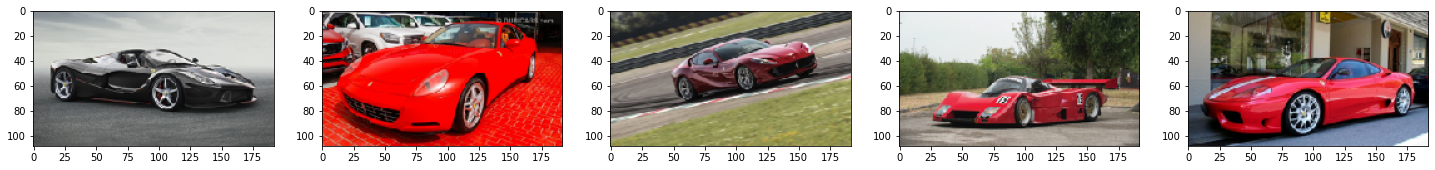

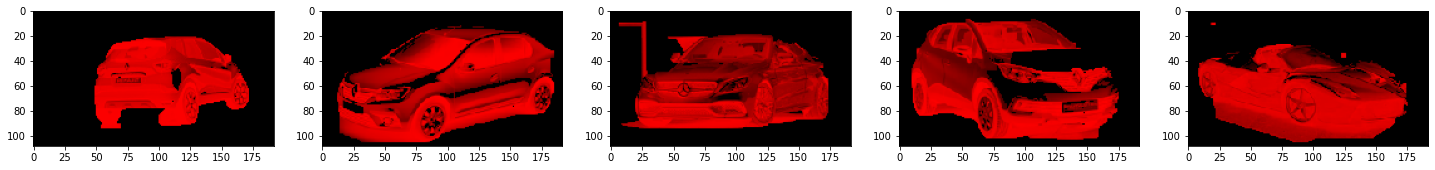

In [ ]:
show_images(X)
show_images(Y)

In [ ]:
print(X.shape)
print(Y.shape)

(1000, 108, 192, 3)
(1000, 108, 192, 3)


In [ ]:
def color2index(color):
    index=0
    if (color[0] + color[1] + color[2]) > 20  : index = 1 # самолет    
    return index

def index2color(index):
    new_index = np.argmax(index)
    color=[]
    if new_index == 0:
        color = [0, 0, 0] 
    elif new_index == 1:
        color = [255, 0, 0]  
    return color

def rgbToohe(y, num_classes): 
    y_shape = y.shape 
    y = y.reshape(y.shape[0] * y.shape[1], 3) 
    yt = [] 
    for i in range(len(y)): 
        yt.append(utils.to_categorical(color2index(y[i]), num_classes=num_classes)) 
    yt = np.array(yt) 
    yt = yt.reshape(y_shape[0], y_shape[1], num_classes) 
    return yt

def yt_prep(data, num_classes):
    yTrain = [] 
    for seg in data: 
        y = image.img_to_array(seg) 
        y = rgbToohe(y, num_classes)
        yTrain.append(y) 
        # if len(yTrain) % 100 == 0: 
        #     print(len(yTrain)) 
    return np.array(yTrain)

In [ ]:
xTrain = [] 
for img in X: 
    x = image.img_to_array(img) 
    xTrain.append(x) 
    
xTrain = np.array(xTrain)

yTrain = yt_prep(Y, num_classes) 

print(xTrain.shape)
print(yTrain.shape)

(1000, 108, 192, 3)
(1000, 108, 192, 2)


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(xTrain, yTrain, test_size = 0.1)

In [ ]:
print(x_train.shape)
print(y_train.shape)

(900, 108, 192, 3)
(900, 108, 192, 2)


In [ ]:
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

In [ ]:
def unet(num_classes = 2, input_shape= (108, 192, 3)):
    img_input = Input(input_shape)                                         

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)                                            
    x = Activation('relu')(x)                                              

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)         
    x = BatchNormalization()(x)                                            
    block_1_out = Activation('relu')(x)                                    

    x = MaxPooling2D()(block_1_out)                                        

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)        
    x = BatchNormalization()(x)                                            
    x = Activation('relu')(x)                                             

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)       
    x = BatchNormalization()(x)                                            
    block_2_out = Activation('relu')(x)                                    

    x = MaxPooling2D()(block_2_out)                                        

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)        
    x = BatchNormalization()(x)                                            
    x = Activation('relu')(x)                                              

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)        
    x = BatchNormalization()(x)                                            
    x = Activation('relu')(x)                                              

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)        
    x = BatchNormalization()(x)                                            
    block_3_out = Activation('relu')(x)                                    

    x = MaxPooling2D()(block_3_out)                                        

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)        
    x = BatchNormalization()(x)                                            
    x = Activation('relu')(x)                                              

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)        
    x = BatchNormalization()(x)                                            
    x = Activation('relu')(x)                                              

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)        
    x = BatchNormalization()(x)                                            
    block_4_out = Activation('relu')(x)                                    
    x = block_4_out 

    # UP 2
    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(x)
    x = Conv2DTranspose(256, (2, 1), strides=(1, 1), padding='valid')(x)   
    x = BatchNormalization()(x)                                            
    x = Activation('relu')(x)                                              

    x = concatenate([x, block_3_out])                                      
    x = Conv2D(256, (3, 3), padding='same')(x)                             
    x = BatchNormalization()(x)                                            
    x = Activation('relu')(x)                                             

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)                                            
    x = Activation('relu')(x)                                              

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)    
    x = BatchNormalization()(x)                                            
    x = Activation('relu')(x)                                             

    x = concatenate([x, block_2_out])                                      
    x = Conv2D(128, (3, 3), padding='same')(x)                            
    x = BatchNormalization()(x)                                           
    x = Activation('relu')(x)                                             

    x = Conv2D(128, (3, 3), padding='same')(x) 
    x = BatchNormalization()(x) 
    x = Activation('relu')(x) 

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x) 
    x = Activation('relu')(x) 

    x = concatenate([x, block_1_out])  
    x = Conv2D(64, (3, 3), padding='same')(x) 
    x = BatchNormalization()(x) 
    x = Activation('relu')(x) 

    x = Conv2D(64, (3, 3), padding='same')(x) 
    x = BatchNormalization()(x) 
    x = Activation('relu')(x) 

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)  

    model = Model(img_input, x) 

   
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model

In [ ]:
model = unet(2, (108, 192, 3))
history = model.fit(x_train, y_train, epochs=35, batch_size=16, validation_data = (x_val, y_val))

Epoch 1/35
33/57 [================>.............] - ETA: 10:41 - loss: 0.3642 - dice_coef: 0.7798